In [1]:
import pyximport
import numpy as np
pyximport.install(setup_args={"include_dirs": np.get_include()},
                  reload_support=True)
from algorithms.knn_neighborhood import UserKNN
import pandas as pd
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import KFold
import matplotlib.pyplot as plt
from datetime import datetime as dt
from collections import defaultdict
import os
import psutil
import pickle as pl
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mannwhitneyu, norm, shapiro, ttest_ind
import sys

In [2]:
data_df = pd.read_csv("data/ml-100k/u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"], usecols=["user_id", "item_id", "rating"])
reader = Reader(rating_scale=(1, 5))

dataset = Dataset.load_from_df(data_df, reader=reader)
folds = KFold(n_splits=5)

In [9]:
Ks = [5, 10, 15, 20, 25, 30]
Taus = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
mae_mat = np.zeros((len(Ks), len(Taus)))
for trainset, testset in folds.split(dataset):
    sim = UserKNN.compute_similarities(trainset, min_support=1)
    gain = UserKNN.compute_gain(trainset)
    for k_idx, k in enumerate(Ks):
        for tau_idx, tau in enumerate(Taus):
            model = UserKNN(k=k, precomputed_sim=sim, precomputed_gain=gain, tau_4=tau)
            model.fit(trainset)
            predictions = model.test(testset)
            mae = accuracy.mae(predictions, verbose=False)
            print(k_idx, tau_idx, mae)
            mae_mat[k_idx, tau_idx] = mae
            
    break
mae_mat

0 0 0.8524583176906035
0 1 0.8432145550374441
0 2 0.8309168152881291
0 3 0.8245561573804109
0 4 0.8180391702206247
0 5 0.8150620355057208
0 6 0.8170745673855113
0 7 0.820327899884477
0 8 0.8223244560609492
0 9 0.828392867490276
0 10 0.874005116463656
1 0 0.8179256640409429
1 1 0.8134195034823073
1 2 0.8080169509829158
1 3 0.8014976053362763
1 4 0.8000100231277015
1 5 0.8004967457681857
1 6 0.8010051259643335
1 7 0.8028260240595085
1 8 0.8058621039460211
1 9 0.8121757824425613
1 10 0.8355706431575701
2 0 0.8086546968702322
2 1 0.8058435662042004
2 2 0.8016490173912197
2 3 0.7973209452021262
2 4 0.7959805195459894
2 5 0.7958626130245053
2 6 0.7968769545134635
2 7 0.797975375094622
2 8 0.8013594344868009
2 9 0.8086844273543168
2 10 0.8254686766880066
3 0 0.8044236204019934
3 1 0.8033373152850957
3 2 0.799699106398891
3 3 0.7965682884304697
3 4 0.7948973659850507
3 5 0.7953841740409774
3 6 0.7949875457268889
3 7 0.7965868142568001
3 8 0.8002006120356929
3 9 0.8067264961790501
3 10 0.819407

array([[0.85245832, 0.84321456, 0.83091682, 0.82455616, 0.81803917,
        0.81506204, 0.81707457, 0.8203279 , 0.82232446, 0.82839287,
        0.87400512],
       [0.81792566, 0.8134195 , 0.80801695, 0.80149761, 0.80001002,
        0.80049675, 0.80100513, 0.80282602, 0.8058621 , 0.81217578,
        0.83557064],
       [0.8086547 , 0.80584357, 0.80164902, 0.79732095, 0.79598052,
        0.79586261, 0.79687695, 0.79797538, 0.80135943, 0.80868443,
        0.82546868],
       [0.80442362, 0.80333732, 0.79969911, 0.79656829, 0.79489737,
        0.79538417, 0.79498755, 0.79658681, 0.80020061, 0.8067265 ,
        0.81940726],
       [0.80245233, 0.80088818, 0.7984345 , 0.79586032, 0.79433202,
        0.79399963, 0.79490388, 0.79686564, 0.80025946, 0.80696409,
        0.81667861],
       [0.80124448, 0.79998126, 0.79825363, 0.79617297, 0.79385062,
        0.79382078, 0.79526905, 0.79689328, 0.79996485, 0.80713021,
        0.81507842]])

Text(0.5, 0, 'Trade-off $\\tau$')

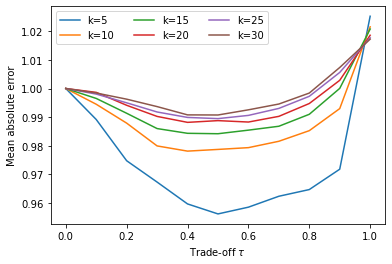

In [19]:
for k_idx, row in enumerate(mae_mat):
    plt.plot(Taus, row / row[0], label="k=%d" % Ks[k_idx])
plt.legend(ncol=3)
plt.ylabel("Mean absolute error")
plt.xlabel(r"Trade-off $\tau$")